In [2]:
import pandas as pd
import re,string
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import sent_tokenize, word_tokenize
import matplotlib.pyplot as plt
import warnings
%pylab inline
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [3]:
df = pd.read_csv("Scraper/amazon.csv")
print(df.dtypes)
print(df.shape)

Title                    object
Date Written             object
Rating                  float64
Current/Former           object
Job Title                object
Location                 object
Recommendation?          object
Outlook                  object
Main Text                object
Pros                     object
Cons                     object
Advice to management     object
dtype: object
(25056, 12)


In [4]:
#df.columns = 
df.columns = ['title', 'date_written', 'rating', 'current_former', 'job_title',
       'location', 'recommendation', 'outlook', 'main_text', 'pros', 'cons',
       'advice_to_management']

In [4]:
df.head()

,title,date_written,rating,current_former,job_title,location,recommendation,outlook,main_text,pros,cons,advice_to_management
0,"""Account Manager""","Sep 9, 2018",3.0,Former Employee,Anonymous Employee,NaN,Recommends,NaN,- Fun environment and excellent team,- Proactive scenario,Almost none opportunities to grow or to move t...,NaN
1,"""All the ""bad"" things you heard about Amazon i...","Sep 9, 2018",1.0,Former Employee,Software Developer,"Seattle, WA",Doesn't Recommend,Negative Outlook,I worked at Amazon full-time (More than a year),You get to work a LOT of hours.,Work life balance is extremely bad. Work here ...,Hopeless
2,"""Amazon is giving hard time to the employees""","Sep 9, 2018",1.0,Current Employee,Fruad Prevention,Hyderabad (India),Doesn't Recommend,Negative Outlook,Becoming worst day by day,All I can say is Amazon has been changed drast...,Working at Amazon is the con,NaN
3,"""Amazon Warehouse Operative""","Sep 9, 2018",1.0,Current Employee,Anonymous Employee,NaN,Doesn't Recommend,Negative Outlook,I have been working at Amazon full-time,Weekly pay was a plus,"Treated as a number, long hours and no flexibi...",Treat staff equal
4,"""Amazon was the easiest job and I was surround...","Sep 9, 2018",5.0,Former Employee,Associate,"Essex, MD",Recommends,Positive Outlook,I worked at Amazon full-time (Less than a year),"Fun, easy, positive energy, surrounded by cool...",Long hours but you’ll get used to it,NaN


In [37]:
#combining pros and cons and cleaning it up
df['pc']= df.pros + ' ' + df.cons

In [38]:
df.pc = df.pc.astype(str)

In [39]:
stop = set(stopwords.words('english'))
punc = string.punctuation    

def clean_tokenize(s):
    s = re.sub(r'[^\w\s]', '',s)
    return([word for word in word_tokenize(s.lower()) if word not in stop if word not in punc])

df['pc_clean'] = df.pc.apply(clean_tokenize)
df["pc_cunique"] = df.pc_clean.map(lambda x: sorted(set(x)))

## Word cloud

In [7]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [8]:
text = df.pc.sum()

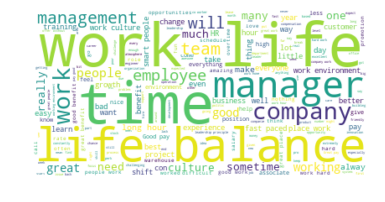

In [16]:
stop = set(STOPWORDS)
stop.update(['amazon','Amazon','lot','employee','job'])
wordcloud = WordCloud(stopwords=stop, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [18]:
wordcloud.to_file("amazon.png")

## Cosine similarity of reviews and values

In [31]:
#Following are the amazon values:

values = ['Customer Obsession Ownership Invent and Simplify Are Right A Lot Learn and Be Curious Hire and Develop the Best Insist on the Highest Standards Think BigBias for Action Frugality Earn Trust Dive Deep Have Backbone; Disagree and Commit Deliver Results']

In [46]:
x= df.pc_cunique[0]
' '.join(x)
# type(df.pc_cunique[0])
# type(values)

'almost another grow move none opportunities proactive scenario team'

In [12]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
df['stemmed'] = df['pc'].map(lambda x: ' '.join([stemmer.stem(y) for y in x.split(' ')]))
df.stemmed.head()

0    - proactiv scenario almost none opportun to gr...
1    you get to work a lot of hours. work life bala...
2    all i can say is amazon has been chang drastic...
3    week pay was a plus treat as a number, long ho...
4    fun, easy, posit energy, surround by cool peop...
Name: stemmed, dtype: object

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

cvec = CountVectorizer(stop_words='english', min_df=1, max_df=.5, ngram_range=(1,2))
cvec

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [14]:
from itertools import islice
cvec.fit(df.stemmed)
list(islice(cvec.vocabulary_.items(), 20))

[('proactiv', 161950),
 ('scenario', 180920),
 ('opportun', 142637),
 ('grow', 89313),
 ('anoth', 10716),
 ('team', 201486),
 ('proactiv scenario', 161966),
 ('scenario opportun', 180927),
 ('opportun grow', 142877),
 ('grow anoth', 89330),
 ('anoth team', 10818),
 ('lot', 121807),
 ('hours', 98306),
 ('life', 117026),
 ('balanc', 17642),
 ('extrem', 74386),
 ('bad', 17127),
 ('plan', 156030),
 ('unhappi', 214412),
 ('miserable', 132257)]

In [15]:
cvec = CountVectorizer(stop_words='english', min_df=.0025, max_df=.1, ngram_range=(1,2))
cvec.fit(df.stemmed)
len(cvec.vocabulary_)

1313

In [17]:
cvec_counts = cvec.transform(df.stemmed)
print('sparse matrix shape:', cvec_counts.shape)
print('nonzero count:', cvec_counts.nnz)
print('sparsity: %.2f%%' % (100.0 * cvec_counts.nnz / (cvec_counts.shape[0] * cvec_counts.shape[1])))

sparse matrix shape: (25056, 1313)
nonzero count: 329232
sparsity: 1.00%


In [18]:
occ = np.asarray(cvec_counts.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'term': cvec.get_feature_names(), 'occurrences': occ})
counts_df.sort_values(by='occurrences', ascending=False).head(20)

,term,occurrences
259,day,3117
1122,team,3025
870,place,2590
789,opportun,2582
335,employe,2552
660,long,2515
105,benefit,2505
646,like,2499
509,hard,2384
690,make,2325


In [19]:
transformer = TfidfTransformer()
transformed_weights = transformer.fit_transform(cvec_counts)
transformed_weights

<25056x1313 sparse matrix of type '<class 'numpy.float64'>'
	with 329232 stored elements in Compressed Sparse Row format>

In [20]:
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': cvec.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(20)

,term,weight
1122,team,0.019147
105,benefit,0.018890
259,day,0.018432
870,place,0.018319
660,long,0.017666
789,opportun,0.017195
642,life,0.016888
335,employe,0.016831
509,hard,0.016201
350,environ,0.016076


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.csr import csr_matrix #need this if you want to save tfidf_matrix

tf = TfidfVectorizer(analyzer='word', ngram_range=(1,6),min_df = 0, stop_words = 'english')

#tf = TfidfVectorizer(ngram_range=(1,3), min_df = 0, stop_words = 'english')
#tf = TfidfVectorizer()
#pc_list = df.pc_cunique.map(lambda x : ' '.join(x))

In [10]:
tfidf_matrix =  tf.fit_transform(df['pc'])
tfidf_matrix.toarray()

MemoryError: 

In [36]:
pc_list = df.pc_cunique.sum()

AttributeError: 'DataFrame' object has no attribute 'pc_cunique'

In [ ]:
def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])
    sum1 = sum([vec1[x]**2 for x in vec1.keys()])
    sum2 = sum([vec2[x]**2 for x in vec2.keys()])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
    return 0.0
    else:
    return float(numerator) / denominator

In [26]:
from collections import Counter

def text_to_vector(text):
    words = WORD.findall(text)
    return Counter(words)

WORD = re.compile(r'\w+')

text1 = df["pc_cunique"]
text2= values
#print(text_to_vector(text1))
print(text_to_vector(text2))

Counter({'and': 4, 'the': 2, 'Customer': 1, 'Obsession': 1, 'Ownership': 1, 'Invent': 1, 'Simplify': 1, 'Are': 1, 'Right': 1, 'A': 1, 'Lot': 1, 'Learn': 1, 'Be': 1, 'Curious': 1, 'Hire': 1, 'Develop': 1, 'Best': 1, 'Insist': 1, 'on': 1, 'Highest': 1, 'Standards': 1, 'Think': 1, 'BigBias': 1, 'for': 1, 'Action': 1, 'Frugality': 1, 'Earn': 1, 'Trust': 1, 'Dive': 1, 'Deep': 1, 'Have': 1, 'Backbone': 1, 'Disagree': 1, 'Commit': 1, 'Deliver': 1, 'Results': 1})


In [32]:
weights = tvec_weights.toarray()
weights_df = pd.DataFrame({'term': tvec.get_feature_names(), 'weight': weights})
weights_df.head()

Exception: Data must be 1-dimensional

In [33]:
def get_postings_and_reverse_postings(document):
    """Read filename and populate the word_freq and reverse_postings dictionary"""
    reverse_postings = {}
    postings = {}

    for word in document:
        postings[word] = {}
        if word in postings[full_quote]:
            postings[full_quote][word] += 1
        else:
            postings[full_quote][word] = 1
        
        if word in reverse_postings:
            if full_quote in reverse_postings[word]:
                    reverse_postings[word][full_quote] += 1
                else:
                    reverse_postings[word][full_quote] = 1
            else:
                reverse_postings[word] = {full_quote:1}

    return postings, reverse_postings

In [35]:
def tfidf(word, full_quote, postings, reverse_postings):
    max_freq = -1
    for w, freq in postings[full_quote].iteritems():
        if freq > max_freq:
            max_freq = freq
    tf = 1.0 * postings[full_quote][word] / max_freq
    
    doc_freq_for_word = len(reverse_postings[word])
    N = len(postings.keys())
    idf = math.log(float(N) / doc_freq_for_word)
    
    tfidf = tf * idf
    print('tf={} idf={} tfidf={} N={} df={}'.format(tf, idf, tfidf, N, doc_freq_for_word))
    return tfidf

In [41]:
document = df.pc_clean.sum()

In [48]:
document

['proactive',
 'scenario',
 'almost',
 'none',
 'opportunities',
 'grow',
 'move',
 'another',
 'team',
 'get',
 'work',
 'lot',
 'hours',
 'work',
 'life',
 'balance',
 'extremely',
 'bad',
 'work',
 'plan',
 'unhappy',
 'miserable',
 'crying',
 'desk',
 'everyday',
 'exaggeration',
 'amazon',
 'squeeze',
 'every',
 'drop',
 'life',
 'say',
 'amazon',
 'changed',
 'drastically',
 'trying',
 'implement',
 'cost',
 'cutting',
 'everything',
 'implementing',
 'hsbc',
 'policies',
 'working',
 'amazon',
 'con',
 'weekly',
 'pay',
 'plus',
 'treated',
 'number',
 'long',
 'hours',
 'flexibility',
 'work',
 'fun',
 'easy',
 'positive',
 'energy',
 'surrounded',
 'cool',
 'people',
 'long',
 'hours',
 'youll',
 'get',
 'used',
 'worked',
 'really',
 'wonderful',
 'hardworker',
 'miss',
 'push',
 'number',
 'daunting',
 'managers',
 'need',
 'bit',
 'compassion',
 'get',
 'learn',
 'manythings',
 'growth',
 'slow',
 'fair',
 'good',
 'environment',
 'friendly',
 'people',
 'easy',
 'work',
 '

In [43]:
document.split()

AttributeError: 'list' object has no attribute 'split'

In [45]:
document.count('amazon')

4825

In [46]:
document['amazon']

TypeError: list indices must be integers or slices, not str

In [ ]:
def termFrequency(term, document):
    return document.count(term.lower()) / float(len(document))

def inverseDocumentFrequency(term, allDocuments):
    numDocumentsWithThisTerm = 0
    for doc in allDocuments:
        if term.lower() in allDocuments[doc].lower().split():
            numDocumentsWithThisTerm = numDocumentsWithThisTerm + 1
 
    if numDocumentsWithThisTerm > 0:
        return 1.0 + log(float(len(allDocuments)) / numDocumentsWithThisTerm)
    else:
        return 1.0

## Sentiment Analysis

In [58]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

def get_sentiment_scores(sentence):
    snt = analyser.polarity_scores(sentence)
    return(snt['compound'])

def get_pos_neg(sentence):
    snt = analyser.polarity_scores(sentence)
    if(snt['pos'] > snt['neg']):
        return('pos')
    return('neg')

In [59]:
df['sent_score'] = df.pc.map(get_sentiment_scores)
df['pos_neg'] = df.pc.map(get_pos_neg)
df.head()

,title,date_written,rating,current_former,job_title,location,recommendation,outlook,main_text,pros,cons,advice_to_management,pc,pc_clean,pc_cunique,sent_score,pos_neg
0,"""Account Manager""","Sep 9, 2018",3.0,Former Employee,Anonymous Employee,NaN,Recommends,NaN,- Fun environment and excellent team,- Proactive scenario,Almost none opportunities to grow or to move t...,NaN,- Proactive scenario Almost none opportunities...,"[proactive, scenario, almost, none, opportunit...","[almost, another, grow, move, none, opportunit...",0.2250,pos
1,"""All the ""bad"" things you heard about Amazon i...","Sep 9, 2018",1.0,Former Employee,Software Developer,"Seattle, WA",Doesn't Recommend,Negative Outlook,I worked at Amazon full-time (More than a year),You get to work a LOT of hours.,Work life balance is extremely bad. Work here ...,Hopeless,You get to work a LOT of hours. Work life bala...,"[get, work, lot, hours, work, life, balance, e...","[amazon, bad, balance, crying, desk, drop, eve...",-0.9412,neg
2,"""Amazon is giving hard time to the employees""","Sep 9, 2018",1.0,Current Employee,Fruad Prevention,Hyderabad (India),Doesn't Recommend,Negative Outlook,Becoming worst day by day,All I can say is Amazon has been changed drast...,Working at Amazon is the con,NaN,All I can say is Amazon has been changed drast...,"[say, amazon, changed, drastically, trying, im...","[amazon, changed, con, cost, cutting, drastica...",0.2263,pos
3,"""Amazon Warehouse Operative""","Sep 9, 2018",1.0,Current Employee,Anonymous Employee,NaN,Doesn't Recommend,Negative Outlook,I have been working at Amazon full-time,Weekly pay was a plus,"Treated as a number, long hours and no flexibi...",Treat staff equal,"Weekly pay was a plus Treated as a number, lon...","[weekly, pay, plus, treated, number, long, hou...","[flexibility, hours, long, number, pay, plus, ...",0.0258,pos
4,"""Amazon was the easiest job and I was surround...","Sep 9, 2018",5.0,Former Employee,Associate,"Essex, MD",Recommends,Positive Outlook,I worked at Amazon full-time (Less than a year),"Fun, easy, positive energy, surrounded by cool...",Long hours but you’ll get used to it,NaN,"Fun, easy, positive energy, surrounded by cool...","[fun, easy, positive, energy, surrounded, cool...","[cool, easy, energy, fun, get, hours, long, pe...",0.7650,pos


In [62]:
print(df.groupby('current_former')[['sent_score']].mean())
print(df.groupby('outlook')[['sent_score']].mean())
print(df.groupby('recommendation')[['sent_score']].mean())

                  sent_score
current_former              
Current Employee    0.465811
Former Employee     0.388745
                  sent_score
outlook                     
Negative Outlook    0.166517
Neutral Outlook     0.363882
Positive Outlook    0.512006
                                    sent_score
recommendation                                
Doesn't Recommend                      0.25585
Recommend 5 day week 8 hours a day     0.00000
Recommends                             0.53145


Anonymous Employee                  9885
Warehouse Associate                  653
Fulfillment Associate                592
Software Development Engineer        573
Area Manager                         302
Software Development Engineer II     269
Customer Service Associate           246
Software Development Engineer I      225
Associate                            217
Software Engineer                    212
Picker                               202
Process Assistant                    178
Program Manager                      175
Operations Manager                   174
CSA                                  171
Senior Product Manager               165
Software Development Manager         149
Manager                              135
Packer                               131
Seller Support Associate             130
Name: job_title, dtype: int64


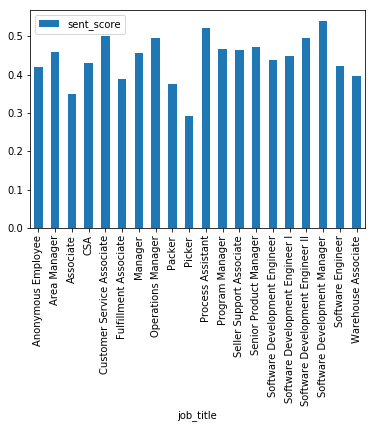

In [63]:
print(df.job_title.value_counts()[:20])
top_designations = df.job_title.value_counts().index[:20]
df[df.job_title.isin(top_designations)].groupby('job_title')[['sent_score']].mean().plot(kind='bar')

In [76]:
print(df.location.value_counts()[:5])
top_locations = df.location.value_counts().index[:5]
df[df.location.isin(top_locations)].groupby('location')['sent_score'].mean().nlargest(10)
#df.groupby('location')['sent_score'].mean().nlargest(10)

Seattle, WA             3862
Bengaluru (India)       1132
Hyderabad (India)       1109
Chennai (India)          633
London, England (UK)     284
Name: location, dtype: int64


location
Seattle, WA             0.499431
Hyderabad (India)       0.487939
Chennai (India)         0.474653
Bengaluru (India)       0.451013
London, England (UK)    0.420635
Name: sent_score, dtype: float64

In [77]:
df[df.location.isin(top_locations) & df.job_title.isin(top_designations) ].groupby(['location','job_title'])[['sent_score']].mean()

sent_score
location             job_title                                   
Bengaluru (India)    Anonymous Employee                  0.398590
                     Associate                           0.495457
                     CSA                                 0.812600
                     Customer Service Associate          0.869200
                     Manager                             0.301622
                     Operations Manager                  0.550236
                     Process Assistant                   0.784500
                     Program Manager                     0.328469
                     Seller Support Associate            0.573355
                     Senior Product Manager              0.454255
                     Software Development Engineer       0.299115
                     Software Development Engineer I     0.387269
                     Software Development Engineer II    0.519337
                     Software Development Manager        0.668987
                     Software Engineer                   0.300613
Chennai (India)      Anonymous Employee                  0.452101
                     Associate                           0.629782
                     Customer Service Associate          0.901700
                     Manager                             0.428667
                     Operations Manager                  0.422342
                     Process Assistant                   0.796100
                     Program Manager                     0.633637
                     Seller Support Associate           -0.350750
                     Software Development Engineer       0.256100
                     Software Development Engineer I     0.460420
                     Software Development Engineer II    0.541320
                     Software Development Manager        0.709600
                     Software Engineer                  -0.060933
                     Warehouse Associate                -0.427800
Hyderabad (India)    Anonymous Employee                  0.489030
...                                                           ...
London, England (UK) Manager                             0.236475
                     Operations Manager                  0.669050
                     Packer                             -0.113150
                     Picker                              0.000000
                     Program Manager                     0.374667
                     Senior Product Manager              0.068860
                     Software Development Engineer       0.341878
                     Software Development Engineer I     0.603300
                     Software Development Engineer II    0.523100
                     Software Development Manager        0.831075
                     Software Engineer                   0.649125
                     Warehouse Associate                 0.900700
Seattle, WA          Anonymous Employee                  0.508740
                     Area Manager                        0.470600
                     Associate                           0.624900
                     CSA                                 0.306075
                     Customer Service Associate          0.502742
                     Fulfillment Associate               0.408775
                     Manager                             0.499074
                     Operations Manager                  0.483793
                     Process Assistant                   0.557400
                     Program Manager                     0.511061
                     Seller Support Associate            0.380375
                     Senior Product Manager              0.474728
                     Software Development Engineer       0.480374
                     Software Development Engineer I     0.406625
                     Software Development Engineer II    0.482596
                     Software Development Manager        0.476099
                     Software